# Project Name : Tumor classification

## Project type: Classification

## Contribuition: Individual

# Project Summary:


### This project is about the classification of Tumor through the provided MRI images. The dataset contain different folders of training, testing, and validating and these folders contain MRI images of three types of tumor(Glioma, Pituitary, meningioma) and a folder of images of patients which have no tumor. I imported libraries for data analysis, loading and resizing images. I used tensorflow keras for creating Neural network and used VGG16 pretrained model for transfer learning, and used LabelEncoder for encoding the categorical labels of the images.

# Github link:- 

# Problem Statement:

## This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# Importing the libraries

In [1]:
import pandas as pd, numpy as np,matplotlib.pyplot as plt, seaborn as snb , os, cv2 as cv,random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Input, MaxPool2D,BatchNormalization, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16
import joblib as jb

2025-07-23 22:28:08.724952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 22:28:08.944495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading the dataset and arranging it

In [2]:
# Enter you path to the training folder 
base_path = r"/home/kartike/python_project/data/Tumor_data/train/"
def load_dataset(base_path):
    disease_path =[]
    for disease in os.listdir(base_path):
        if disease != "_classes.csv":
            disease_path.append(os.path.join(base_path,disease))
    disease = {'glioma':None,'meningioma':None,'pituitary':None,'no_tumor':None}
    for i,keys in enumerate(disease.keys()):
        List = []
        for image in os.listdir(disease_path[i]):
            List.append(os.path.join(disease_path[i],image))
        disease[keys] = List
    return disease
disease = load_dataset(base_path)
disease

{'glioma': ['/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0452_jpg.rf.263a773d71ab2e17e79e7d07a59f21c7.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0329_jpg.rf.f054f10ed40b49aaa09ebc4bfd71230f.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0303_jpg.rf.8c3ab2414c57b28b23cfd0a243e2f646.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0204_jpg.rf.ddfa714b945b43f79a48b49020fd1896.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0222_jpg.rf.2c73214f0866a4d3d6aa40cdf9892be6.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0393_jpg.rf.90ecf59d07643431f1e5fce834915109.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0344_jpg.rf.6ee7ad0ef821653b01aa9f608545ae84.jpg',
  '/home/kartike/python_project/data/Tumor_data/train/glioma/Tr-gl_0365_jpg.rf.2405a85652a8f284e2bdf0c13320d440.jpg',
  '/home/kartike/python_project/data/Tumor_dat

# Created  a function to dislay random image of a partiuclar disease

(640, 640, 3)


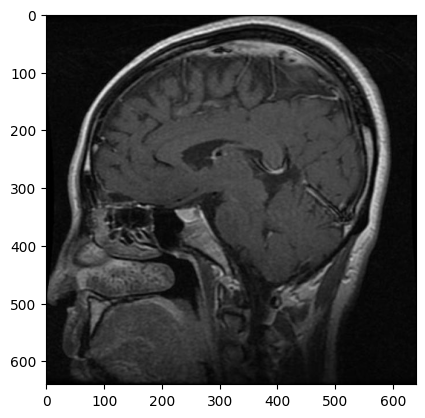

In [3]:
disease_name = ['glioma','meningioma','pituitary','no_tumor']
# A function to load random images of a particular disease 
def show_image(disease_name):
    image = cv.imread(disease[disease_name][random.randint(0,len(disease[disease_name]))])
    plt.imshow(image)
    image = np.array(image)
    print(image.shape)
show_image('pituitary')


# creating a dataframe of path and labels of dataset

In [4]:
# merging different dataframes of the disease
df = pd.DataFrame({'Image_path':disease['glioma'],'Label':['glioma' for i in range(len(disease['glioma']))]})
df1 = pd.DataFrame({'Image_path':disease['meningioma'],'Label':['meningioma' for i in range(len(disease['meningioma']))]})
df2 = pd.DataFrame({'Image_path':disease['pituitary'],'Label':['pituitary' for i in range(len(disease['pituitary']))]})
df3 = pd.DataFrame({'Image_path':disease['no_tumor'],'Label':['no_tumor' for i in range(len(disease['no_tumor']))]})
df = pd.concat([df,pd.concat([df1,pd.concat([df2,df3])])])
df

,Image_path,Label
0,/home/kartike/python_project/data/Tumor_data/t...,glioma
1,/home/kartike/python_project/data/Tumor_data/t...,glioma
2,/home/kartike/python_project/data/Tumor_data/t...,glioma
3,/home/kartike/python_project/data/Tumor_data/t...,glioma
4,/home/kartike/python_project/data/Tumor_data/t...,glioma
...,...,...
330,/home/kartike/python_project/data/Tumor_data/t...,no_tumor
331,/home/kartike/python_project/data/Tumor_data/t...,no_tumor
332,/home/kartike/python_project/data/Tumor_data/t...,no_tumor
333,/home/kartike/python_project/data/Tumor_data/t...,no_tumor


# Loaded the image and resizing the image

In [5]:
# loading, resizing and normalization function 
def load_and_resize_image(path, size=(224, 224)):
    img = cv.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = cv.resize(img, size)
    img = img.astype(np.float32) / 255.0  # normalize
    return img

# Replace each image path with its corresponding matrix
df['Image_matrix'] = df['Image_path'].apply(lambda path: load_and_resize_image(path))
df = df.drop(columns=['Image_path'])

df

,Label,Image_matrix
0,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
330,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
331,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
332,no_tumor,"[[[0.4392157, 0.4392157, 0.4392157], [0.137254..."
333,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [6]:
#There were total 1695 images of every disease in the dataset 
df['Image_matrix'].shape

(1695,)

# Encoding the labels

In [7]:
# Following are the different ways to do the encoding of the images 

# label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'no_tumor': 3}
# df['label'] = df['Label'].map(label_map)
# df = df.drop(columns= ['Label'])
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df

,Label,Image_matrix
0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
330,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
331,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
332,2,"[[[0.4392157, 0.4392157, 0.4392157], [0.137254..."
333,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


# stacking up the array of images

In [8]:
x_train,y_train = np.stack(df['Image_matrix'].values),to_categorical(df['Label'],num_classes=4)
x_train

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [9]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [10]:
type(y_train)

numpy.ndarray

# Similar data extraction, label encoding, creating dataframe for test data

In [11]:

disease_name = ['glioma','meningioma','pituitary','no_tumor']

base_path = r"/home/kartike/python_project/data/Tumor_data/test/"
disease = load_dataset(base_path)


df = pd.DataFrame({'Image_path':disease['glioma'],'Label':['glioma' for i in range(len(disease['glioma']))]})
df1 = pd.DataFrame({'Image_path':disease['meningioma'],'Label':['meningioma' for i in range(len(disease['meningioma']))]})
df2 = pd.DataFrame({'Image_path':disease['pituitary'],'Label':['pituitary' for i in range(len(disease['pituitary']))]})
df3 = pd.DataFrame({'Image_path':disease['no_tumor'],'Label':['no_tumor' for i in range(len(disease['no_tumor']))]})
df = pd.concat([df,pd.concat([df1,pd.concat([df2,df3])])])

# Replace each image path with its corresponding matrix
df['Image_matrix'] = df['Image_path'].apply(lambda path: load_and_resize_image(path))
df = df.drop(columns=['Image_path'])


# label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'no_tumor': 3}
# df['label'] = df['Label'].map(label_map)
# df = df.drop(columns= ['Label'])
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df


,Label,Image_matrix
0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
44,2,"[[[0.019607844, 0.019607844, 0.019607844], [0...."
45,2,"[[[0.015686275, 0.015686275, 0.015686275], [0...."
46,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
47,2,"[[[0.003921569, 0.003921569, 0.003921569], [0...."


In [12]:
df['Image_matrix'].head(10)

0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
5    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
6    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
7    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
8    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
9    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: Image_matrix, dtype: object

In [13]:
x_test,y_test = np.stack(df['Image_matrix'].values),to_categorical(df['Label'],num_classes=4)


# Checking number of GPU's

In [14]:
#checking the number of gpu's in the system 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


# Creating the Neural Network and storing model variables according to number of gpus

In [15]:
# If Mulitple gpu's are present, enabling them to use alternative and synchronously training with the help of MirroredStrategy function from tensorflow 

strategy = tf.distribute.MirroredStrategy()
if len(tf.config.experimental.list_physical_devices('GPU')) > 1:
    with strategy.scope():
        # Creating my own Neural Network 
        model = Sequential([
            Input(shape=(224,224,3)),
        
            Conv2D(32,(3,3),activation='relu'),
            MaxPool2D((2,2)),
        
            Conv2D(64,(3,3),activation='relu'), 
            MaxPool2D((2,2)), 
        
        
            Flatten(), 
            Dense(128,activation='relu'), 
            Dense(4,activation='softmax')
        ]
        )
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
else:
    model = Sequential([
            Input(shape=(224,224,3)),
        
            Conv2D(32,(3,3),activation='relu'),
            MaxPool2D((2,2)),
        
            Conv2D(64,(3,3),activation='relu'), 
            MaxPool2D((2,2)), 
        
        
            Flatten(), 
            Dense(128,activation='relu'), 
            Dense(4,activation='softmax')
        ]
        )
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


# Training own designed CNN

In [17]:

if len(tf.config.experimental.list_physical_devices('GPU')) > 1:
    
    with strategy.scope():
        history1 = model.fit(
            x_train,y_train,
            batch_size=64,
            epochs=5,
            validation_data=(x_test,y_test)
        )
else:
    history1 = model.fit(
            x_train,y_train,
            batch_size=32,
            epochs=5,
            validation_data=(x_test,y_test)
        )


53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9024 - val_loss: 0.4817


# Summary of model

In [ ]:
model.summary()


In [19]:
del model

In [20]:
from tensorflow.keras import backend as K
K.clear_session()

# Loading base model for Transfer learning

In [ ]:
model_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3),
)

In [ ]:
model_base.summary()

# Adding new dense layer

In [ ]:
dense_model = Sequential()

dense_model.add(model_base)
dense_model.add(Flatten())
dense_model.add(Dense(256,activation='relu'))
dense_model.add(Dense(4,activation = 'softmax'))

# Freezing VGG16 model from training

In [ ]:
model_base.trainable = False

# Summary of the model

In [ ]:
dense_model.summary()

In [ ]:
dense_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )

# Training transfer learning model

In [ ]:
history2 = dense_model.fit(x_train,y_train,
                          epochs=5,
                          batch_size=64,
                         validation_data=(x_test,y_test))

# Comparing evaluation score

In [ ]:
loss,acc = model.evaluate(x_test,y_test)
loss1,acc1 = dense_model.evaluate(x_test,y_test)

# Graphical comparison

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First subplot: CNN Model
axes[0].plot(history1.history['loss'], color='red', label='train')
axes[0].plot(history1.history['val_loss'], color='blue', label='validation')
axes[0].set_title('CNN MODEL')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Second subplot: Transfer Learning Model
axes[1].plot(history2.history['loss'], color='red', label='train')
axes[1].plot(history2.history['val_loss'], color='blue', label='validation')
axes[1].set_title('Transfer Learning')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


# Saving model with the better score

In [18]:
model.save("/home/kartike/python_project/Tumor_prediction/model.h5")